# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [2]:
import cv2
import PIL
import torchvision

print('cv2 ==> {}'.format(cv2.__version__))
print('PIL ==> {}'.format(PIL.__version__))
print('torchvision ==> {}'.format(torchvision.__version__))

cv2 ==> 3.3.1
PIL ==> 5.2.0
torchvision ==> 0.2.1


Number of faces detected: 2


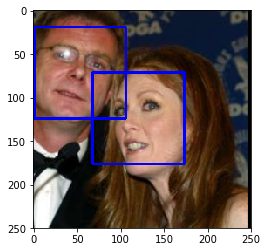

In [3]:
import cv2 #Import OpenCV                
import matplotlib.pyplot as plt                        
%matplotlib inline                               


# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[42]) #42 or 47 for two faces
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h), color=(255,0,0), thickness=2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
As can be seen, this algorithm does not achieve 100% correct answers, neither in human faces nor in dogs. The exact percentages appear in the cell below.

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

#short = 400
#human_files_short = human_files[:short]
#dog_files_short = dog_files[:short]

n_faces = 0
n_dogs = 0
for k in tqdm(range(0,len(human_files_short))):
    n_faces += 1 if face_detector(human_files_short[k]) else 0
    n_dogs += 1 if face_detector(dog_files_short[k]) else 0

percentage_faces = 100 * n_faces /len(human_files_short)
percentage_dogs = 100 * n_dogs /len(human_files_short)

print("Percentage of faces detected in human files: {:.2f}%".format(percentage_faces))
print("Percentage of faces detected in dog files: {:.2f}%".format(percentage_dogs))

100%|██████████| 100/100 [00:33<00:00,  3.03it/s]

Percentage of faces detected in human files: 98.00%
Percentage of faces detected in dog files: 17.00%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# define inception model
inception = models.inception_v3(pretrained=True)

# define googlenet model
# torchvision 0.2.1 has no model googlenet, it works with version 0.5.0
#googlenet = models.googlenet(pretrained=True)

# define resnet50 model
resnet50 = models.resnet50(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    inception = inception.cuda()
    #googlenet = googlenet.cuda()
    resnet50 = resnet50.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Load image from img_path in PIL format
    image = Image.open(img_path)
    
    # Define normalization parameters mean and stdv
    # Values from: https://pytorch.org/docs/stable/torchvision/models.html
    normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225))
    
    # Define transformation pipeline
    transform = transforms.Compose([transforms.Resize(256), # n x n
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   normalizer])
    # Apply transformation
    image = transform(image)
    
    # Add a dimension
    image_tensor = image.unsqueeze(0)
    
    # Tensor to GPU if available
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    # Get prediction
    VGG16.eval()
    prediction = VGG16(image_tensor)
    VGG16.train()
    
    # Get class index
    #class_index = prediction.argmax() # Tensor format
    class_index = torch.argmax(prediction).item() # Single value format
    
    return class_index # predicted class index

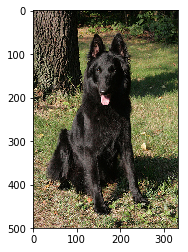

Predicted class: 224 


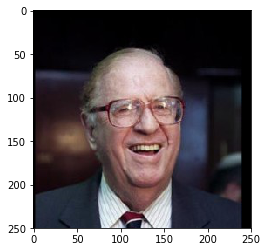

Predicted class: 906 


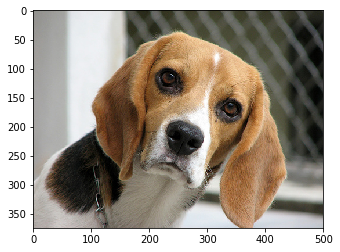

Predicted class: 162 


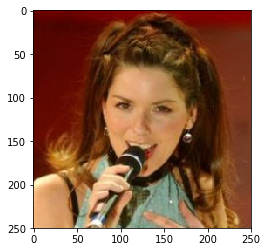

Predicted class: 650 


In [8]:
# Checking

# load filenames for human and dog images
#human_files in "/data/lfw/*/*"
#dog_files in "/data/dog_images/*/*/*"

image_path_arr = ['/data/dog_images/train/021.Belgian_sheepdog/Belgian_sheepdog_01483.jpg',
                  '/data/lfw/Abba_Eban/Abba_Eban_0001.jpg',
                  '/data/dog_images/train/016.Beagle/Beagle_01145.jpg',
                  '/data/lfw/Shania_Twain/Shania_Twain_0001.jpg']

for image_path in image_path_arr:
    # Read image
    image = cv2.imread(image_path)

    # Get predicted class from image path
    class_prediction = VGG16_predict(image_path)

    # Convert BGR image to RGB for displaying
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(rgb_image)
    plt.show()
    print('Predicted class: %d ' % class_prediction)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, model='VGG16'):
    ## TODO: Complete the function.
    
    # Get predicted class from image path
    if model == 'GoogleNet':
        class_prediction = googlenet_predict(img_path)
    elif model == 'InceptionV3':
        class_prediction = inception_predict(img_path)
    elif model == 'ResNet50':
        class_prediction = resnet50_predict(img_path)
    else:
        class_prediction = VGG16_predict(img_path)
    
    # See if index is into the range [151,268]
    result = 151 <= class_prediction <= 268
    
    return result # true/false

In [10]:
def display_image(img_path, model='VGG16'):
    """ This function has as input a path to an image, and returns
    the image displayed, and prints messages showing the predicted class
    if there is a dog in the image. """
        
    # Get image
    image = cv2.imread(im_path)
    
    # Get predicted class from image path
    if model == 'GoogleNet':
        class_prediction = googlenet_predict(img_path)
    elif model == 'InceptionV3':
        class_prediction = inception_predict(img_path)
    elif model == 'ResNet50':
        class_prediction = resnet50_predict(img_path)
    else:
        class_prediction = VGG16_predict(img_path)
    
    # Get true or false if it's a dog
    is_dog = dog_detector(im_path)
    
    # Display image, predicted class and if is a dog or not
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()
    print('There is a dog in the image: {}'.format(is_dog))
    print('Predicted class: %d ' % class_prediction)

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In this case, with this sample, the VGG16 has worked perfectly. It has been correct in all cases, whether there was a dog in the photo or not. The percentages can be seen in the execution of the cell below.

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs = []
humans = []
for dog, human in tqdm(zip(dog_files_short, human_files_short)):
    dogs.append(dog_detector(dog, 'VGG16'))
    humans.append(dog_detector(human, 'VGG16'))
    
print("VGG16. Percentage of dogs detected in human files: {}%".format(np.sum(humans)))
print("VGG16. Percentage of dogs detected in dog files: {}%".format(np.sum(dogs)))

100it [00:07, 14.93it/s]

VGG16. Percentage of dogs detected in human files: 0%
VGG16. Percentage of dogs detected in dog files: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

    ### (Optional) 
    ### TODO: Report the performance of another pre-trained network.
    ### Feel free to use as many code cells as needed.

In [12]:
def inception_predict(img_path):
    '''
    Use pre-trained InceptionV3 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to InceptionV3 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Load image from img_path in PIL format
    image = Image.open(img_path)
    
    # Define normalization parameters mean and stdv
    # Values from: https://pytorch.org/docs/stable/torchvision/models.html
    normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225))
    
    # Define transformation pipeline
    transform = transforms.Compose([transforms.Resize(360),
                                   transforms.CenterCrop(300), # Carefull, this version has a minimum of 299
                                   transforms.ToTensor(),
                                   normalizer])
    # Apply transformation
    image = transform(image)
    
    # Add a dimension
    image_tensor = image.unsqueeze(0)
    
    # Tensor to GPU if available
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    # Get prediction
    inception.eval()
    prediction = inception(image_tensor)
    inception.train()
    
    # Get class index
    #class_index = prediction.argmax() # Tensor format
    class_index = torch.argmax(prediction).item() # Single value format
    
    return class_index # predict

__Answer:__
The result of the same process, with the same sample, but with InceptionV3 is also very good. In this case only a single image has been misclassified, as can be seen below.

In [13]:
dogs = []
humans = []
for dog, human in tqdm(zip(dog_files_short, human_files_short)):
    dogs.append(dog_detector(dog, 'InceptionV3'))
    humans.append(dog_detector(human, 'InceptionV3'))
    
print("InceptionV3. Percentage of dogs detected in human files: {}%".format(np.sum(humans)))
print("InceptionV3. Percentage of dogs detected in dog files: {}%".format(np.sum(dogs)))

100it [00:08, 11.70it/s]

InceptionV3. Percentage of dogs detected in human files: 0%
InceptionV3. Percentage of dogs detected in dog files: 99%


In [14]:
def resnet50_predict(img_path):
    '''
    Use pre-trained InceptionV3 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to InceptionV3 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Load image from img_path in PIL format
    image = Image.open(img_path)
    
    # Define normalization parameters mean and stdv
    # Values from: https://pytorch.org/docs/stable/torchvision/models.html
    normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225))
    
    # Define transformation pipeline
    transform = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   normalizer])
    # Apply transformation
    image = transform(image)
    
    # Add a dimension
    image_tensor = image.unsqueeze(0)
    
    # Tensor to GPU if available
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    # Get prediction
    resnet50.eval()
    prediction = resnet50(image_tensor)
    resnet50.train()
    
    # Get class index
    #class_index = prediction.argmax() # Tensor format
    class_index = torch.argmax(prediction).item() # Single value format
    
    return class_index # predict

__Answer:__
Again I have done the same process as before, but in this case with Resnet50. The result, as with VGG16, has been excellent.

In [15]:
dogs = []
humans = []
for dog, human in tqdm(zip(dog_files_short, human_files_short)):
    dogs.append(dog_detector(dog, 'ResNet50'))
    humans.append(dog_detector(human, 'ResNet50'))
    
print("ResNet50. Percentage of dogs detected in human files: {}%".format(np.sum(humans)))
print("ResNet50. Percentage of dogs detected in dog files: {}%".format(np.sum(dogs)))

100it [00:05, 17.90it/s]

ResNet50. Percentage of dogs detected in human files: 0%
ResNet50. Percentage of dogs detected in dog files: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [16]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_dir = '/data/dog_images/train/'
valid_dir = '/data/dog_images/valid/'
test_dir = '/data/dog_images/test/'

normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225))

In [17]:
# Define transformations

train_transform = transforms.Compose([transforms.RandomRotation(degrees=10),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.2),
                                      transforms.ToTensor(),
                                      normalizer])

valid_transform = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       normalizer])

test_transform = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       normalizer])

In [18]:
# Load the datasets

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_data = datasets.ImageFolder(train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

In [19]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle = True, num_workers=0)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers=0)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

I have not followed exactly the same procedure for all three datasets. The dimensions of the images in all of them will end up being 224x224 which seems to be a good value so it doesn't take up too much space or lose too much image information (it's the same value that was used in the original VGG16 paper from 2015); however in the case of the train dataset I apply a random rotation and also a horizontal flip with a certain probability.
See that in the case of the train dataset, cropping is also done directly without prior scaling. All this is aimed at achieving a certain augmentation, which gives more randomness to the data, thus preventing from overfitting.

In the case of validation and test datasets, simply I scale the image first and then I crop it to the desired value, since in this case the data will only be used to know how good the fit is.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv1 = nn.Conv2d( 3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d( 32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d( 64, 128, kernel_size=3, stride=1, padding=1)

        # nn.MaxPool2d(kernel_size, stride, padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # nn.Linear(in_features, out_features)
        self.fc1 = nn.Linear(28*28*128, 1330)
        self.fc2 = nn.Linear(1330, 133)

        # nn.Dropout(p=0.5)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x))) # 224 x 224 x 3 --> 112 x 112 x 32 
        x = self.pool(F.relu(self.conv2(x))) # 112 x 112 x 32 --> 56 x 56 x 64
        x = self.pool(F.relu(self.conv3(x))) # 56 x 56 x 64 --> 28 x 28 x 128

        x = x.view(-1, 28*28*128) # Flatten  
        #x = self.dropout(x) # Dropout

        x = self.dropout(x)
        x = F.relu(self.fc1(x)) # 28 x 28 x 128 = 100352 --> 1330

        x = self.dropout(x)
        x = self.fc2(x) # 1330 --> 133

        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I have done many attemps. It was clear that I had to use convolutional neural networks, so I started there. The first few times I ran out of memory because I was doing really extensive networks. Then I have lowered expectations and have ended up making the network that I describe.
A first convolutional layer of 32 outputs, followed by two others that multiply their depth by two (with filters 3x3 and stride=1 and padding=1). Among them there are maxpool layers that divide height and width by two.
Finally, as a classifier, two fully connected layers with their previous dropout and with a Relu type activation layer in the first one.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [21]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss() 

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.02)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [23]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    last_saved_epoch = 0
    max_epochs_lost = 4
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad() # Clear gradientes
            output = model(data) # Implicit forward pass
            loss = criterion(output, target) # Calculate loss
            loss.backward() # Back propagation
            optimizer.step() # Optimization step
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased from {:.6f} to {:.6f}) in epoch {}. Saved!'.format(
                valid_loss_min, valid_loss, epoch))
            valid_loss_min = valid_loss
            last_saved_epoch = epoch
            
        #if epoch - last_saved_epoch == max_epochs_lost:
        #    break

    # return trained model
    return model

# train the model
model_scratch = train(80, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.861532 	Validation Loss: 4.736734
Validation loss decreased from inf to 4.736734) in epoch 1. Saved!
Epoch: 2 	Training Loss: 4.692237 	Validation Loss: 4.566020
Validation loss decreased from 4.736734 to 4.566020) in epoch 2. Saved!
Epoch: 3 	Training Loss: 4.601110 	Validation Loss: 4.447113
Validation loss decreased from 4.566020 to 4.447113) in epoch 3. Saved!
Epoch: 4 	Training Loss: 4.526424 	Validation Loss: 4.464279
Epoch: 5 	Training Loss: 4.472898 	Validation Loss: 4.413535
Validation loss decreased from 4.447113 to 4.413535) in epoch 5. Saved!
Epoch: 6 	Training Loss: 4.420023 	Validation Loss: 4.273934
Validation loss decreased from 4.413535 to 4.273934) in epoch 6. Saved!
Epoch: 7 	Training Loss: 4.379973 	Validation Loss: 4.235120
Validation loss decreased from 4.273934 to 4.235120) in epoch 7. Saved!
Epoch: 8 	Training Loss: 4.331298 	Validation Loss: 4.152653
Validation loss decreased from 4.235120 to 4.152653) in epoch 8. Saved!
Epoch: 9 	Tra

In [24]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [25]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.366614


Test Accuracy: 47% (3200/6680)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [26]:
## TODO: Specify data loaders

# I use the same datal oaders from the previous step (CNN from scratch)
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [27]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture

# Use VGG16 model
model_transfer = models.vgg16(pretrained=True)

In [28]:
model_transfer # I have a look to the model to see the classifier that I want to substitute

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [29]:
model_transfer.classifier # I can replace only the number of output features, but I could also define a new one

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [30]:
output_features_class = 133 # number of dog breeds
input_features_class = model_transfer.classifier[0].in_features
print('Number of input features in the classifier: {}'.format(input_features_class))
print('Number of output features in the classifier: {}'.format(output_features_class))

Number of input features in the classifier: 25088
Number of output features in the classifier: 133


In [31]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Leave imported model's parameters blocked to brackpropagation
for param in model_transfer.parameters():
    param.requires_grad = False

In [32]:
# Create my new classifier
custom_classifier = nn.Sequential(nn.Linear(input_features_class, 4096),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(4096, 1024),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(1024, output_features_class))

# Put into the model the new classifier
model_transfer.classifier = custom_classifier

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The original architecture is designed to classify many different types of objects in the images. In this case I am only using the dog breed identification functionality.
My classifier has to be able to adapt to the output of the last convolutional layer and end up classifying correctly. I think that for this task I don't need as many layers as the original VGG. What I have done has been looking at the number of input features to the classifier, and adapting it in two stages to the number of outputs required (133).
I have also tried with three fully connected layers; but the calculation time grows and the improvement wasn't remarkable.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [33]:
criterion_transfer = nn.CrossEntropyLoss() 
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.02)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_transfer, 'min')

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [34]:
def train(n_epochs, loaders, model, optimizer, scheduler, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    last_saved_epoch = 0
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad() # Clear gradientes
            output = model(data) # Implicit forward pass
            loss = criterion(output, target) # Calculate loss
            loss.backward() # Back propagation
            optimizer.step() # Optimization step
            ## record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased from {:.6f} to {:.6f}) in epoch {}. Saved!'.format(
                valid_loss_min, valid_loss, epoch))
            valid_loss_min = valid_loss
            last_saved_epoch = epoch

        # Update learning rate
        scheduler.step(valid_loss)
        
        # Break the loop if the loss is not decreasing any more
        #if epoch - last_saved_epoch >= max_epochs_lost:
        #    break
        
    # return trained model
    return model
            

# train the model
# train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, scheduler, criterion_transfer,
                       #use_cuda, 'model_transfer.pt')
model_transfer = train(30, loaders_scratch, model_transfer, optimizer_transfer, scheduler, criterion_transfer,
                       use_cuda, 'model_transfer.pt')




Epoch: 1 	Training Loss: 3.494495 	Validation Loss: 1.602229
Validation loss decreased from inf to 1.602229) in epoch 1. Saved!
Epoch: 2 	Training Loss: 2.143434 	Validation Loss: 1.336281
Validation loss decreased from 1.602229 to 1.336281) in epoch 2. Saved!
Epoch: 3 	Training Loss: 1.858991 	Validation Loss: 1.030082
Validation loss decreased from 1.336281 to 1.030082) in epoch 3. Saved!
Epoch: 4 	Training Loss: 1.746351 	Validation Loss: 0.870301
Validation loss decreased from 1.030082 to 0.870301) in epoch 4. Saved!
Epoch: 5 	Training Loss: 1.634979 	Validation Loss: 0.840274
Validation loss decreased from 0.870301 to 0.840274) in epoch 5. Saved!
Epoch: 6 	Training Loss: 1.604146 	Validation Loss: 0.872695
Epoch: 7 	Training Loss: 1.601866 	Validation Loss: 0.829482
Validation loss decreased from 0.840274 to 0.829482) in epoch 7. Saved!
Epoch: 8 	Training Loss: 1.554110 	Validation Loss: 0.853543
Epoch: 9 	Training Loss: 1.513561 	Validation Loss: 0.803098
Validation loss decrease

In [35]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [36]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.639593


Test Accuracy: 82% (5490/6680)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [37]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_scratch['train'].dataset.classes]

def predict_breed_transfer(img_path):
    '''
    Args:
        img_path: path to an image
        
    Returns:
        String with the dog's breed name
    '''
    
    # Load image from img_path in PIL format
    image = Image.open(img_path)
    
    # Define normalization parameters mean and stdv
    # Values from: https://pytorch.org/docs/stable/torchvision/models.html
    normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                     std=(0.229, 0.224, 0.225))
    
    # Define transformation pipeline
    transform = transforms.Compose([transforms.Resize(256), # n x n
                                   transforms.CenterCrop(224), # Recorte
                                   transforms.ToTensor(),
                                   normalizer])
    # Apply transformation
    image = transform(image)
    
    # Add a dimension
    image_tensor = image.unsqueeze(0)
    
    # Tensor to GPU if available
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    # Get prediction
    model_transfer.eval()
    prediction = model_transfer(image_tensor)
    model_transfer.train()
    
    # Get class index
    class_index = prediction.argmax() # Tensor format
    #class_index = torch.argmax(prediction).item() # Single value format
    
    # Use prediction to get dog breed
    breed_name = class_names[class_index]
    
    return breed_name # predicted breed name

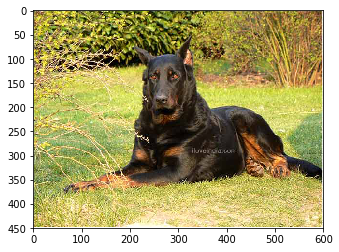

Beauceron


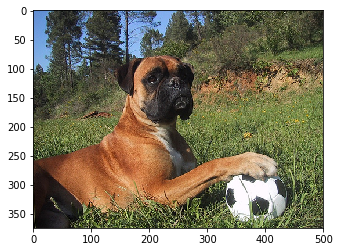

Boxer


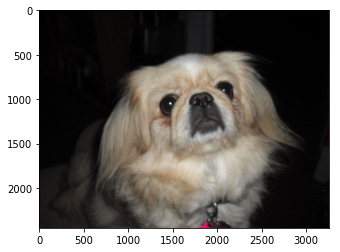

Pekingese


In [38]:
# Test it
image_arr = ['/data/dog_images/train/018.Beauceron/Beauceron_01285.jpg',
         '/data/dog_images/train/034.Boxer/Boxer_02382.jpg',
         '/data/dog_images/train/117.Pekingese/Pekingese_07570.jpg']

for image in image_arr:
    breed = predict_breed_transfer(image)

    # Get image
    img = cv2.imread(image)

    # Display image
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

    # Print breed
    print(breed)

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [39]:
def show_image(img_path):
    """ This function has as input a path to an image, and returns
    the image displayed"""
    
    # Get image
    image = cv2.imread(img_path)
     
    # Display image, predicted class and if is a dog or not
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

In [40]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    is_dog = dog_detector(img_path)
    is_face = face_detector(img_path)
    
    if is_dog or is_face:
        breed = predict_breed_transfer(img_path)
        if is_dog==True:
            print(breed)
        else:
            print('Hi human. You look like a {}'.format(breed))
    else:
        print('Error!!! No dog or human has been detected in this image.')
        
    show_image(img_path)
            


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is better than I expected. Eventhough I think that if I spend a lot of time with it, I could get even a better result (maybe not too much better). Some of the points that I could use to improve the fitting could be as follow:
* I could try with any parameter variation (such as different learning rate updatting, number of epochs, initial values...)
* I could also try with a different loss function. See that I'm using CrossEntropyLoss, but there are other options.
* I could use a different optimizer. I use SGD; maybe I could have tried with Adam.
* I could change completely my classifier structure. I could add a third layer (or more) and try with different number of output features in between.
* I could make more transformations to the initial set of images, or even get more images from other databases.
* See that I've used VGG16 as a pretrained model. I could check how does it work with InceptionV3, Resnet 50 or GoogleNet.
* I also could improve de face detector and dog detector algorithms. This could be done by using again CNN with transfer learning from a good model.

Error!!! No dog or human has been detected in this image.


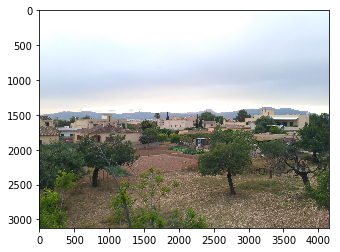

Error!!! No dog or human has been detected in this image.


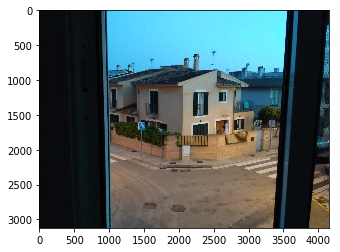

Border collie


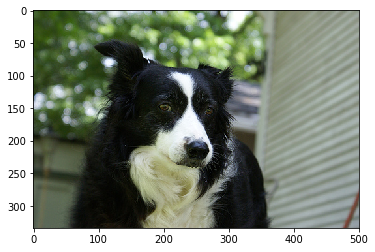

Hi human. You look like a Pharaoh hound


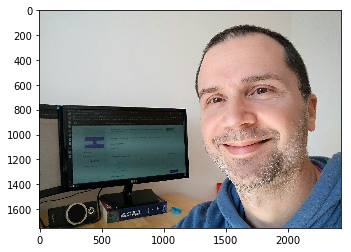

Hi human. You look like a Basenji


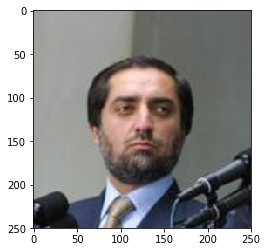

Dalmatian


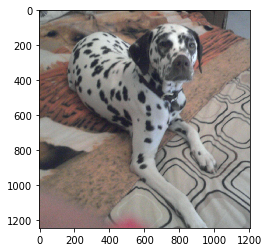

In [42]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
#for file in np.hstack((human_files[:3], dog_files[:3])):
#    run_app(file)

# load filenames for human and dog images
my_images = np.array(glob("final_test_images/*"))
#my_images = np.array(glob("/final_test_images/*"))
for img in my_images:
    run_app(img)  